# Recomendação de filmes utilizando o dataset do MovieLens
## SCC0230 - Inteligência Artificial (2023)
### Grupo: 
       Jônatas Alves Lopes - 11796552 
       Thierry de Souza Araújo - 12681094 
       Rebeca Vieira Carvalho - 12543530 
       Gustavo Lelli Guirao - 11918182 
       Israel Felipe da Silva - 11796531 
       Henrique Garcia Gomes do Ó - 10734331

# 1. Preparação dos dados

### 1.1 Importar Bibliotecas

In [1]:
!pip install numpy pandas mlxtend wget

Defaulting to user installation because normal site-packages is not writeable


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1.2 Dados crus do dataset movieLens

A partir do momento em que os dados na íntegra são lidos, é necessário um tratamento e adaptação para ser possível a manipulação das informações nos próximos passos. Dessa forma, o dataframe é construído a partir dos arquivos _movies_sample.csv_ e _ratings_sample.csv_. É importante destacar que está sendo usada para o desenvolvimento desse projeto um conjunto de dados reduzido do original, disponibilizado por Marcelo Manzato em seu repositório público [MBABigData](https://github.com/mmanzato/MBABigData). A versão completa do dataset é proveniente da base de dados [MovieLens](https://grouplens.org/datasets/movielens/).



In [46]:
import wget
# !python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
# # Botar referência e créditos ao Marcelo Manzato
# !tar -xvzf ml-20m-compact.tar.gz
# # Aprox 400 filmes e 11k usuarios

In [3]:
# Explorar os dados
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])

# Mapeamento em índices
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}
df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)

map_title = {}
for _, row in df.iterrows():
    map_title[row.movieId] = row.title

Informações dos filmes

In [5]:
movies.head()

,movieId,title,genres
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary|IMAX
3,161,Crimson Tide (1995),Drama|Thriller|War
4,193,Showgirls (1995),Drama


Avaliações dos usuários

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788


Dataframe com as informações do usuário e dos filmes avaliados por eles

In [7]:
df.head()

,userId,movieId,rating,title
0,0,0,5.0,Enemy Mine (1985)
1,1,0,4.0,Enemy Mine (1985)
2,2,0,3.0,Enemy Mine (1985)
3,3,0,3.0,Enemy Mine (1985)
4,4,0,3.0,Enemy Mine (1985)


### 1.3 Divisão da base em treino e teste

Para avaliar o desempenho do sistema de recomendação uma certa parcela do dataset é separada para treinar o modelo e outra é usada como base de comparação e valores corretos. Para isso é utilizado a função _model_selection_ da biblioteca _scikit-learn_. Nesse caso, **20%** dos dados são usados para teste e **80%** para o treinamento em si.

In [59]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=.2, random_state=2)

### 1.4 Funções para obter informações específicas do DataFrame

Obter a nota que um usuário deu para um item.

In [5]:
def get_rating(df, userId,movieId):
    if len(df[(df['userId']==userId)&(df['movieId']==movieId)]) == 0:
        return 0
    return (df.loc[(df.userId==userId) & (df.movieId == movieId),'rating'].iloc[0])

get_rating(df, 6102, 413)

3.5

Obter a lista de todos os filmes que um usuário avaliou.

In [47]:
def get_movie_ids(df, userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'movieId'].tolist())

get_movie_ids(df, 0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Obter o título do item dado o seu id.

In [7]:
def get_movie_title(movieId):
    if movieId not in df['movieId'].values:
        return ''
    return (df.loc[(df.movieId == movieId),'title'].iloc[0])

get_movie_title(0)

'Enemy Mine (1985)'

Obter a lista de ratings de um usuário.

In [48]:
def get_user_ratings(df, userId):
    if userId not in df['userId'].values:
        return []
    return (df.loc[(df.userId==userId),'rating'].tolist())

get_user_ratings(df, 0)

[5.0, 4.5, 4.0, 2.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 3.5, 5.0]

Obter a média de ratings de um usuário

In [ ]:
def get_user_mean(df, userId):
    return np.mean(get_user_ratings(df, userId))

get_user_mean(df, 1)

3.38

Obter a lista de todos os usuários que avaliaram o filme

In [49]:
def get_user_ids(df, movieId):
    if movieId not in df['movieId'].values:
        return []
    return (df.loc[(df.movieId==movieId),'userId'].tolist())

get_user_ids(df, 10)[:10]

[0, 3058, 6262, 8209, 9890, 1191, 6263, 3060, 6264, 9891]

Obter todas as notas do filme

In [50]:
def get_movie_ratings(df, movieId):
    if movieId not in df['movieId'].values:
        return []
    return (df.loc[(df.movieId==movieId),'rating'].tolist())

get_movie_ratings(df, 0)[:10]

[5.0, 4.0, 3.0, 3.0, 3.0, 4.0, 5.0, 2.0, 3.5, 3.0]

Obter a média de notas do filme

In [14]:
def get_movie_mean(df, movieId):
    return np.mean(get_movie_ratings(df, movieId))

get_movie_mean(df, 0)

3.4496732026143793

Obter a lista de ratings de um usuário.

In [20]:
def get_user_movie_rate(df, userId, minRate = 0):
    if userId not in df['userId'].values:
        return []
    
    if minRate:
        return (df.loc[(df.userId==userId) & \
                (df.rating >= minRate),['movieId', 'rating']])
                
    return (df.loc[(df.userId==userId),['movieId', 'rating']])

get_user_movie_rate(df, 0, 5)

,movieId,rating
0,0,5.0
7891,4,5.0
13046,5,5.0
17474,6,5.0
19012,7,5.0
24363,9,5.0
25566,10,5.0
31524,12,5.0


# 2. Método Baseline
### Método simples para predição de avaliações baseado em tendências de cada usuário e item

> Recomeda filmes considerando o contexto e os dados tanto dos filmes quanto dos usuários, e a associação entre os filmes e os usuários

### 2.1 Fatores Calculados
Primeiramente, é importante entender os fatores a serem calculados que serão a base para prever a avaliação de um usuário a partir de um item. Em essência há três fatores a serem considerados:

##### a) Média global dos ratings (M)




$$ M = \frac{1}{| r_{ui} \in R |} \sum_{r_{ui} \in R} r_{ui}$$ 
> $R$ é o conjunto de todas as notas.

##### b) Bias do filme (Fbias)




$$ Fbias = \frac{1}{\lambda_{1} + | R(i) |} \sum_{u \in R(i)} r_{ui} - M$$ 
>$R(i)$ é o conjunto de usuários que avaliaram $i$.<br>
>$\lambda_{1}$ é constante.

##### c) Bias do usuário (Ubias)



$$ Ubias = \frac{1}{\lambda_{2} + | R(u) |} \sum_{i \in R(u)} r_{ui} - M - Fbias$$ 
>$R(u)$ é o conjunto de itens avaliados por $u$.<br>
>$\lambda_{2}$ é constante.

#### Implementação do cálculo dos fatores

In [15]:
# Calcula a média global, o viés referente ao filme e ao usuário
def get_bias(df):
    c = 1
    global_mean = df['rating'].mean()
    movie_list = df['movieId'].unique()
    movie_bias = {}
    for i in movie_list:
        users = get_user_ids(df, i)
        movie_bias[i] = sum((get_rating(df, u, i)-global_mean) for u in users) / (len(users) + c)
            
    user_list = df['userId'].unique()
    user_bias = {}
    for u in user_list:
        items = get_movie_ids(df, u)
        user_bias[u] = sum((get_rating(df, u, i)-global_mean-movie_bias[i]) for i in items) / (len(items) + c)

    return global_mean, user_bias, movie_bias

### 2.2 Recomendação

Para calcular a nota do filme dada por um certo usuário são utilizado os fatores anteriormente calculados da seguinte maneira:

$$ Score = M + Fbias + Ubias $$

>Assim, a recomendação consiste em proporcionar ao usuário uma lista ordenada pelos filmes com maior score que ainda não foram assistidos pelo usuário.

In [156]:
# Recomenda filmes que o usuário ainda não assistiu
def RecommendMovies(df, userId, globalMean, userBias, movieBias, k = 5):
    movie_list = df['movieId'].unique()
    watched = get_movie_ids(df, userId)
    recommend = []
    for i in movie_list:
        if(not i in watched):
             # Calcula a suposta nota para o filme
            recommendation_score = globalMean + userBias[userId] + movieBias[i]
            
            recommend.append((i, recommendation_score))

      # Ordena de forma crescente a lista de filmes recomendados pela nota
    recommend.sort(key=lambda x: x[1], reverse=True)
    return recommend[:k]

#### Testes

In [157]:
train_global_mean, train_user_bias, train_movie_bias = get_bias(df_train)

In [19]:
print(train_user_bias)
print(train_movie_bias)

{10794: 0.2637131241746502, 1750: 0.2776119120048822, 4096: 0.25477693834284976, 4244: -0.4507895825603821, 5316: 0.43071003147536907, 1400: -0.157033760632077, 2848: -0.531909673182897, 2411: 0.23613951012950077, 8981: -0.14025773408442416, 8607: 0.02972982764770675, 8064: 0.16696198688687, 6604: -0.3215002754489736, 855: 0.15377915536605785, 9493: 0.22007957668235695, 1106: 0.3310164676144263, 2209: -0.3361784539733506, 8787: 0.2584618669497148, 1978: 0.6151489389369643, 10265: -0.27905244670934465, 1050: -1.0010100164694296, 3952: 0.1608835087882952, 1569: -0.2414409916511022, 8580: -0.031055660478483647, 3841: 0.29795261455192, 6650: 0.06413341799863737, 2663: 0.7831751085252504, 1082: 0.2591183764336755, 355: -0.3245308768839919, 7468: -0.029564592362594014, 5080: 0.5554510244542491, 3648: -0.6784276307221299, 878: -0.06988101797177362, 1528: -1.5772394918746118, 2050: -0.14720242726317398, 9565: 0.24430451550128598, 7245: -0.41489031378399194, 49: -0.1349726803560959, 10252: -0.4

### 2.3 Avaliação do desempenho do algoritmo baseline

#### Obtenção dos filmes não assistidos

In [154]:
# Verifica se a recomendação sugerida pelo método Baseline é um filme
# que o usuário realmente assistiu e deu uma nota maior ou igual a minRate.
def check_recomendations(dfTrain, dfTest, globalMean, userBias, 
                         movieBias, users, minRate, k):

    # Array com a quantidade de vídeos assistidos & recomendados 
    # corretamente pelo baseline para cada usuário
    found = [0]*len(users)

    for idx, user in enumerate(users):
        recomendation = RecommendMovies(dfTrain, user, globalMean, 
                                        userBias, movieBias, k=k)

        test_movies = get_user_movie_rate(dfTest, user, minRate=minRate)
        
        test_movies_list = []
        if len(test_movies) != 0:
            test_movies_list = test_movies['movieId'].tolist()
        
            for movie in recomendation:
                # Verifica se o filme (idMovie) recomendado está na lista de filmes assistidos
                if movie[0] in test_movies_list:
                    found[idx] += 1

            found[idx] /= len(test_movies_list)
    return found

In [29]:
users = df_test['userId'].unique().tolist()
min_rate = 3
found_5 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 5)
found_10 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 10)
found_20 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 20)
found_30 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 30)
found_40 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 40)

print('Média de recomendações vistas para', 5,'recomendações do baseline:', np.mean(found_5))
print('Média de recomendações vistas para', 10,'recomendações do baseline:', np.mean(found_10))
print('Média de recomendações vistas para', 20,'recomendações do baseline:', np.mean(found_20))
print('Média de recomendações vistas para', 30,'recomendações do baseline:', np.mean(found_30))
print('Média de recomendações vistas para', 40,'recomendações do baseline:', np.mean(found_40))

Média de recomendações vistas para 5 recomendações do baseline: 0.4535846900885461
Média de recomendações vistas para 10 recomendações do baseline: 0.6138246215367038
Média de recomendações vistas para 20 recomendações do baseline: 0.7285537465486052
Média de recomendações vistas para 30 recomendações do baseline: 0.8441397695896411
Média de recomendações vistas para 40 recomendações do baseline: 1.0056174426354374


In [ ]:
found_5 = check_recomendations(df_train, df_test, train_global_mean, train_user_bias,
                             train_movie_bias, users, min_rate, 5)
print('Média de recomendações vistas para', 5,'recomendações do baseline:', np.mean(found_5))

#### Erros e desempenho 

In [23]:
# Erro médio absoluto entre as notas previstas e as notas de avaliações reais
amt_movies = df_test['movieId'].unique().size

users = df_test['userId'].unique().tolist()
users.sort()
amt_users = len(users)

# Array que armazenará a diferença absoluta média para cada usuário
diff = []
for user in users:
    # Nota de recomendação para todos os filmes dado o usuário i
    recomendation = RecommendMovies(df_train, user, train_global_mean, 
                                        train_user_bias, train_movie_bias, k=amt_movies)
    watched_movies = get_user_movie_rate(df_test, user)
    
    mean = []
    if len(watched_movies) > 0:
        idmovies = watched_movies['movieId'].tolist()
        ratemovies = watched_movies['rating'].tolist()

        dictMovieRate = {idMovie:rateMovie for idMovie, rateMovie in zip(idmovies, ratemovies)}
       
        for idx, movie in enumerate(recomendation):
            # Se o usuário já assistiu o filme, calcula-se a diferença absoluta e adiciona-se ao array
            if dictMovieRate.get(movie[0], None):
                mean.append(abs(dictMovieRate[movie[0]] - movie[1]))

        if mean:
            diff.append((user, np.mean(mean)))
            mean = []

print(diff)

[(0, 0.7649213365108047), (1, 0.5395555806964393), (2, 1.1201593606693057), (3, 1.057001749366297), (4, 0.297263095192128), (5, 0.47541475737441763), (6, 0.3231004003123604), (7, 0.9505716353082466), (8, 1.1212420591568157), (9, 0.695736244337403), (10, 1.2505108267136589), (11, 0.7802460692325547), (13, 0.23812797665735555), (14, 0.3153175472308935), (15, 0.333776600280177), (16, 0.32349449870763436), (17, 0.6561055685000141), (18, 0.7443042807791054), (19, 0.5506661163459396), (20, 0.3967511634291736), (21, 0.26794967114340673), (22, 0.8761873935801808), (23, 0.7210153799420553), (24, 0.754919831758405), (25, 0.3662594514850184), (26, 0.5208034283508349), (27, 0.5666113274730401), (28, 1.0722295279545393), (29, 0.05645400600169681), (30, 0.4227492566633006), (31, 0.35695108390689184), (32, 1.230430603389081), (33, 0.7857201389385745), (34, 1.0383518041554067), (35, 0.6626986469914421), (36, 1.2628847283139906), (37, 0.8829370969131471), (38, 0.19525117986075435), (40, 0.4354775155864

In [98]:
# Geração de vetor apenas com os erros para plot
diff_errors = [erro[1] for erro in diff]

# Média global dos erros
mean_error = np.mean(diff_errors)

In [99]:
diff_errors.sort()


In [100]:
diff_errors

[0.0008468994655124185,
 0.001614347904395963,
 0.0018710292503834047,
 0.0021645097744791286,
 0.0025087235807257358,
 0.0054819197404976094,
 0.005566881880472607,
 0.005862418756442445,
 0.0065943229158809125,
 0.007038791553703572,
 0.008860719785030113,
 0.008958476866885334,
 0.0091012488922253,
 0.010260697625573467,
 0.010466265907662198,
 0.010609400794350687,
 0.011658094367168026,
 0.01223906344564174,
 0.012986386434408637,
 0.013066277664412596,
 0.013364012831487138,
 0.014818480682997404,
 0.015520848847117907,
 0.01567152790814852,
 0.015885931130190656,
 0.016592392434049863,
 0.016833121465726908,
 0.01749025675193927,
 0.0180053114456884,
 0.018132740434889882,
 0.0188935734882012,
 0.019211540540738703,
 0.019559112858417382,
 0.02052641221347029,
 0.020599228784230927,
 0.02071291822503829,
 0.02140781324847385,
 0.02166302748131077,
 0.022242780917818727,
 0.022706891030039866,
 0.022830082147152098,
 0.023153395556152923,
 0.02323255153901549,
 0.0232445851181459

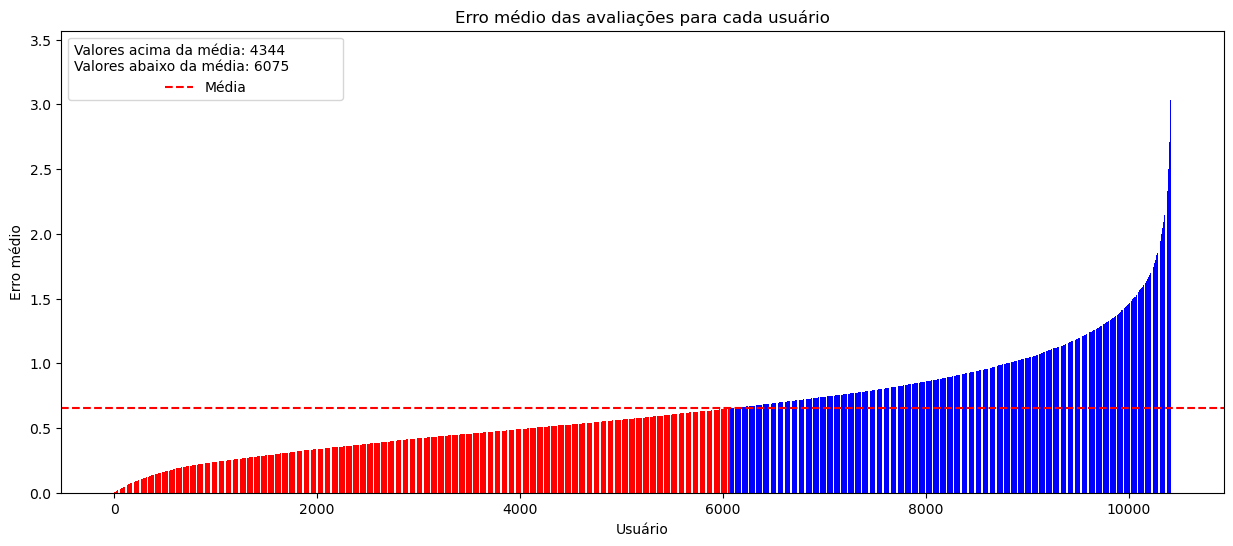

In [101]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(diff_errors)), diff_errors, color=np.where(diff_errors < mean_error, 'red', 'blue'))

plt.axhline(y=np.mean(diff_errors), color='r', linestyle='--', label='Média')

plt.xlabel('Usuário')
plt.ylabel('Erro médio')

upper = np.sum(diff_errors >= mean_error)
bottom = len(diff_errors) - upper
legend = f'Valores acima da média: {upper}\
            \nValores abaixo da média: {bottom}'
plt.legend(title=legend)

plt.title('Erro médio das avaliações para cada usuário')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


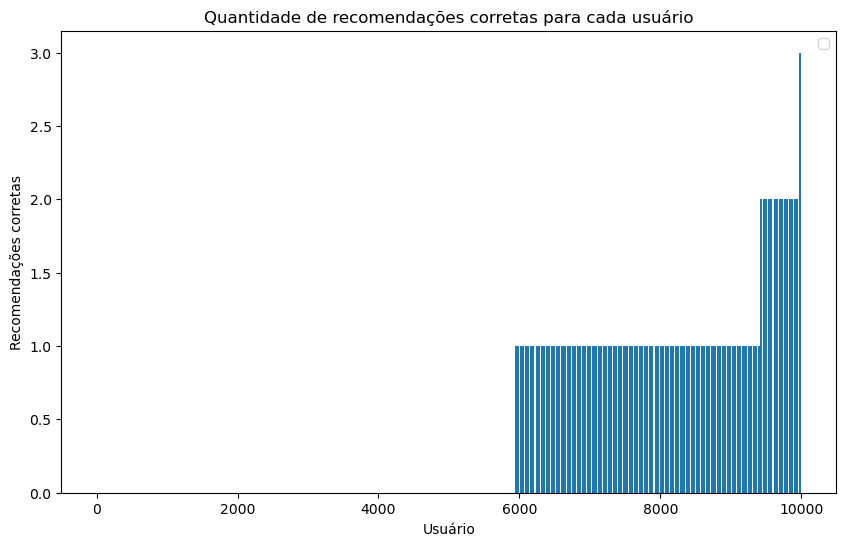

In [140]:
k = 10000
data = found_5[:k]
data.sort()

plt.figure(figsize=(10, 6))
plt.bar(range(len(data)), data)

plt.xlabel('Usuário')
plt.ylabel('Recomendações corretas')

plt.legend()

plt.title('Quantidade de recomendações corretas para cada usuário')
plt.show()

# 3. Modelo Apriori

> Recomenda filmes considerando principalmente o contexto dos filmes e a relação (associação) entre eles

### 3.1 Recomendação com Apriori

O modelo Apriori calcula a probabilidade de determinar o quão propenso um certo usuário está de assistir um filme F1 considerando que ele já assistiu um dado filme F2. Para isso é feito o cálculo do suporte, confiança e lift para diferentes combinações de filme.

#### a) Suporte (S)

Indica a frequência com que um itemset ou com que A e B ocorrem juntos.

$$ S = \frac{freq(A, B)}{N}$$

#### b) Confiança (C)

A confiança de uma regra A => B é a probabilidade condicional da transação conter o conjunto de itens B, dado que contém o conjunto A.

$$ S = \frac{freq(A, B)}{freq(A)}$$

#### c) Lift (L)

É a relação entre confiança e suporte, a probabilidade que a ocorrência de um evento seja influenciada pela ocorrência de outro evento.

$$ L(A\Rightarrow B) = \frac{C(A \Rightarrow B)}{S(B)} = \frac{S(A U B)}{S(A) * S(B)} $$

### 3.2 Pré-processamento e criação da tabela de filmes assistidos

In [60]:
df_pivot = df_train.pivot(index='userId', columns='title', values='rating').fillna(0)

In [61]:
df_pivot = df_pivot.astype('int64')

In [62]:
df_pivot = df_pivot.applymap(lambda x: 1 if x > 0 else 0)

In [63]:
df_pivot.head()


title,100 Rifles (1969),21 (2008),3 Simoa (2012),A Rumor Of War (1980),A mí las mujeres ni fu ni fa (1971),About Cherry (2012),"Ace in the Hole (Big Carnival, The) (1951)",Across the Sea of Time (1995),Adult World (2013),"Adventure in Space and Time, An (2013)",...,While You Were Sleeping (1995),White Nights (1985),Wild Target (2010),"Winning Team, The (1952)",Wish I Was Here (2014),"Woman, a Gun and a Noodle Shop, A (San qiang pai an jing qi) (2009)",Wonderful Days (a.k.a. Sky Blue) (2003),Yolanda and the Thief (1945),Zero Effect (1998),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### 3.3 Treinando o modelo

In [64]:
from mlxtend.frequent_patterns import apriori

frequent_itemset = apriori(df_pivot, min_support=0.07, use_colnames=True)

/home/thierryara/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [73]:
frequent_itemset.head()


,support,itemsets
0,0.073129,(21 (2008))
1,0.121010,(Along Came a Spider (2001))
2,0.318215,(American Psycho (2000))
3,0.109648,(Apocalypto (2006))
4,0.155816,"(Aristocats, The (1970))"


In [74]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemset, metric="lift", min_threshold=1)


In [75]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Reservoir Dogs (1992)),(Along Came a Spider (2001)),0.573219,0.121010,0.071506,0.124744,1.030861,0.002141,1.004267,0.070146
1,(Along Came a Spider (2001)),(Reservoir Dogs (1992)),0.121010,0.573219,0.071506,0.590909,1.030861,0.002141,1.043242,0.034058
2,(Star Wars: Episode V - The Empire Strikes Bac...,(Along Came a Spider (2001)),0.685663,0.121010,0.085302,0.124408,1.028083,0.002330,1.003881,0.086899
3,(Along Came a Spider (2001)),(Star Wars: Episode V - The Empire Strikes Bac...,0.121010,0.685663,0.085302,0.704918,1.028083,0.002330,1.065254,0.031076
4,(Bowling for Columbine (2002)),(American Psycho (2000)),0.364923,0.318215,0.145987,0.400049,1.257169,0.029863,1.136403,0.322106


### 3.4 Resultados


In [83]:
df_res = rules.sort_values(by=['lift'], ascending=False)
df_res.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1958,"(Reservoir Dogs (1992), I, Robot (2004))",(Star Wars: Episode V - The Empire Strikes Bac...,0.181064,0.203877,0.071145,0.392928,1.927278,0.034230,1.311414,0.587510
1959,(Star Wars: Episode V - The Empire Strikes Bac...,"(Reservoir Dogs (1992), I, Robot (2004))",0.203877,0.181064,0.071145,0.348961,1.927278,0.034230,1.257890,0.604346
1953,"(Reservoir Dogs (1992), Star Wars: Episode V -...",(Collateral (2004)),0.128224,0.292696,0.071145,0.554852,1.895660,0.033615,1.588920,0.541973
1964,(Collateral (2004)),"(Reservoir Dogs (1992), Star Wars: Episode V -...",0.292696,0.128224,0.071145,0.243068,1.895660,0.033615,1.151724,0.668000
1031,"(Reservoir Dogs (1992), I, Robot (2004))",(Collateral (2004)),0.181064,0.292696,0.099820,0.551295,1.883506,0.046823,1.576322,0.572786


### 3.5 Testando o modelo

In [115]:
from collections import Counter

# Ordena o vetor pelos mais mais repetidos primeiro
def sort_by_frequency(array):
    # Contar a frequência de cada elemento no array
    count = Counter(array)

    # Ordenar o array com base na contagem de repetições de cada elemento
    sorted_array = sorted(array, key=lambda x: count[x], reverse=True)

    return sorted_array

# Remove os repetidos depois da ordenação
def remove_repeated(array):
    new_array = []
    seen_items = set()

    for movie in array:
        if movie not in seen_items:
            new_array.append(movie)
            seen_items.add(movie)

    return new_array


In [127]:
minRate = 3
get_user_movie_rate(df_train, 10, minRate)['movieId'].tolist()

[183,
 20,
 4,
 93,
 65,
 33,
 16,
 19,
 77,
 17,
 57,
 58,
 111,
 64,
 26,
 34,
 5,
 22,
 14,
 174,
 81,
 12,
 10]

In [148]:
def test_apriori(dfTrain, dfTest, minRate, k):
    users = dfTest['userId'].unique().tolist()
    found = [0]*len(users)

    for idx, user in enumerate(users):
        # Pega os respectivos títulos dos filmes avaliados pelo usuário
        movie_list_test = get_user_movie_rate(dfTrain, user, minRate)['movieId'].tolist()
        
        for i in range(len(movie_list_test)):
            movie_list_test[i] = get_movie_title(movie_list_test[i])
        
        # Com base nos filmes avaliados, pega as recomendações de cada um e armazena
        movies = []
        for movie in movie_list_test:
            df_test_apr = df_res[df_res['antecedents'] \
                                 .apply(lambda x: len(x) == 1 and next(iter(x)) == movie)]
            df_test_apr = df_test_apr[df_test_apr['lift'] > 1.5]
            movies.extend(df_test_apr['consequents'].values)

        # Adicionando os filmes recomendados em uma lista
        movie_list = []
        for movie in movies:
            for title in movie:
                movie_list.append(title)

        # Pegando as k primeiras recomendações
        movie_list = remove_repeated(sort_by_frequency(movie_list))[:k]

        # Obtendo os filmes assistidos pelo usuário 
        movie_list_test = get_user_movie_rate(dfTest, user, minRate)['movieId'].tolist()
        if movie_list_test:
            for i in range(len(movie_list_test)):
                movie_list_test[i] = get_movie_title(movie_list_test[i])

            # Buscando se os filmes recomendados foram realmente assistidos pelo usuário
            for movie in movie_list_test:
                if movie in movie_list:
                    found[idx] += 1

            found[idx] /= len(movie_list_test)

    return found

In [134]:
found_5_ap = test_apriori(df_train, df_test, 3, 5)
found_10_ap = test_apriori(df_train, df_test, 3, 10)
found_20_ap = test_apriori(df_train, df_test, 3, 20)
found_30_ap = test_apriori(df_train, df_test, 3, 30)
found_40_ap = test_apriori(df_train, df_test, 3, 40)

print('Média de recomendações vistas para', 5,'recomendações do Apriori:', np.mean(found_5_ap))
print('Média de recomendações vistas para', 10,'recomendações do Apriori:', np.mean(found_10_ap))
print('Média de recomendações vistas para', 20,'recomendações do Apriori:', np.mean(found_20_ap))
print('Média de recomendações vistas para', 30,'recomendações do Apriori:', np.mean(found_30_ap))
print('Média de recomendações vistas para', 40,'recomendações do Apriori:', np.mean(found_40_ap))

Média de recomendações vistas para 5 recomendações do Apriori: 0.5823098162429782
Média de recomendações vistas para 10 recomendações do Apriori: 0.8561363419975245
Média de recomendações vistas para 20 recomendações do Apriori: 0.983909359230696
Média de recomendações vistas para 30 recomendações do Apriori: 0.9848614681519566
Média de recomendações vistas para 40 recomendações do Apriori: 0.9848614681519566


In [149]:
found_5_ap = test_apriori(df_train, df_test, 3, 5)

### 3.6 Avaliação do Modelo

Este teste gera todas regras geradas, para averiguar a preditibilidade das regras que o algoritmo gera.

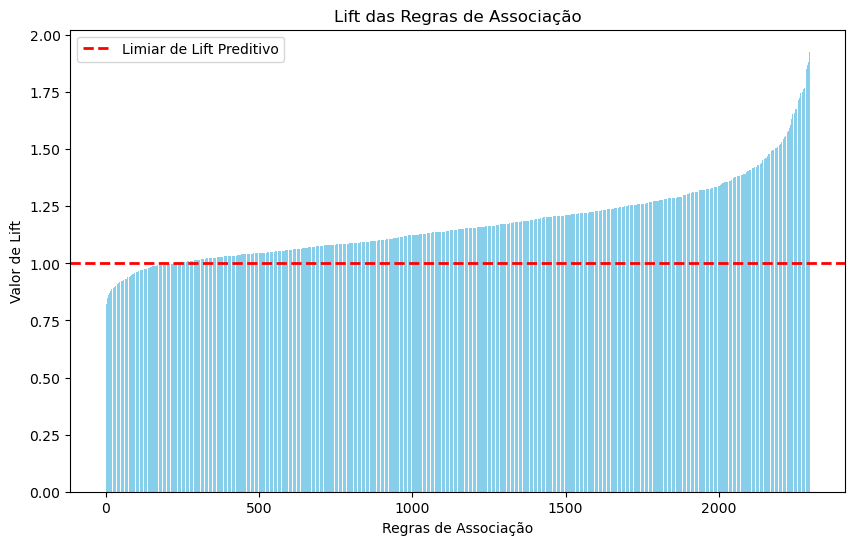

In [77]:
allRules = association_rules(frequent_itemset, metric="lift")
evaluate = allRules.sort_values(by=['lift'], ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(range(len(evaluate)), evaluate['lift'], align='center', color='skyblue')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Limiar de Lift Preditivo')
plt.xlabel('Regras de Associação')
plt.ylabel('Valor de Lift')
plt.title('Lift das Regras de Associação')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


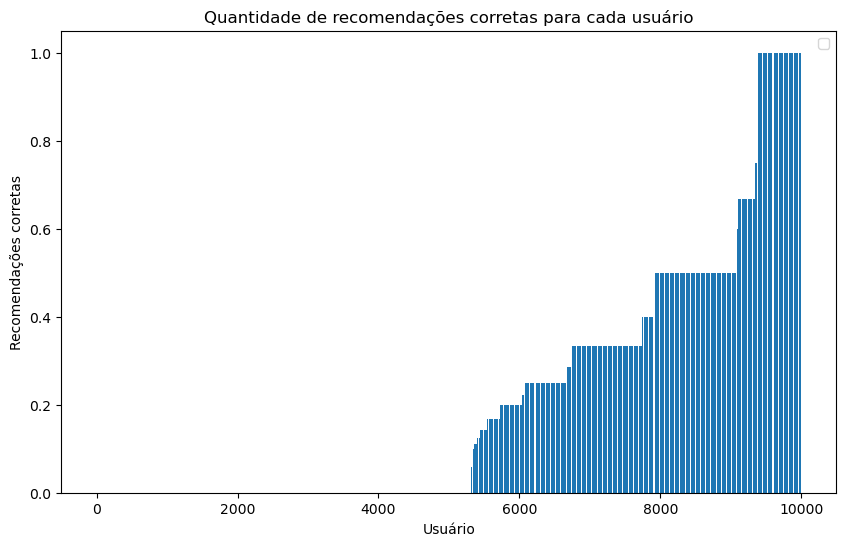

In [150]:
k = 10000
data = found_5_ap[:k]
data.sort()

plt.figure(figsize=(10, 6))
plt.bar(range(len(data)), data)

plt.xlabel('Usuário')
plt.ylabel('Recomendações corretas')

plt.legend()

plt.title('Quantidade de recomendações corretas para cada usuário')
plt.show()

In [143]:
user = 0
found = 0
idx = 0

# Pega os respectivos títulos dos filmes avaliados pelo usuário
movie_list_test = get_user_movie_rate(df_train, user, minRate)['movieId'].tolist()

for i in range(len(movie_list_test)):
    movie_list_test[i] = get_movie_title(movie_list_test[i])

# Com base nos filmes avaliados, pega as recomendações de cada um e armazena
movies = []
for movie in movie_list_test:
    df_test_apr = df_res[df_res['antecedents'] \
                            .apply(lambda x: len(x) == 1 and next(iter(x)) == movie)]
    df_test_apr = df_test_apr[df_test_apr['lift'] > 1.5]
    movies.extend(df_test_apr['consequents'].values)

# Adicionando os filmes recomendados em uma lista
movie_list = []
for movie in movies:
    for title in movie:
        movie_list.append(title)

# Pegando as k primeiras recomendações
movie_list = remove_repeated(sort_by_frequency(movie_list))[:k]

# Obtendo os filmes assistidos pelo usuário 
movie_list_test = get_user_movie_rate(df_test, user, minRate)['movieId'].tolist()
for i in range(len(movie_list_test)):
    movie_list_test[i] = get_movie_title(movie_list_test[i])

# Buscando se os filmes recomendados foram realmente assistidos pelo usuário
for movie in movie_list_test:
    if movie in movie_list:
        found += 1

found /= len(movie_list_test)
found


0.5

# 4. Modelo K-Nearest-Neighbors

> Recomenda filmes com base nas preferências de usuários semelhantes

### 4.1 Filtragem colaborativa

Como um método alternativo temos o K-Nearest-Neighbors, que se baseia no conceito de filtragem colaborativa. Nesse sentido, temos como ideias principais os seguintes tópicos:
- Escolha de K vizinhos que serão considerados.
- O algoritmo verifica os K pontos de dados mais próximos a ele no espaço de características.
- Cosseno como medida de similaridade: vetores representam os padrões de avaliações de usuários para diferentes itens.
- Calcula a média ponderada das classificações dos K vizinhos mais próximos.

In [159]:
!pip install scikit-surprise

from surprise import Dataset, Reader, KNNBasic

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

Defaulting to user installation because normal site-packages is not writeable


### 4.2 Implementação

In [160]:
# Essa função Percorre todos os dados de treinamento disponíveis e extrai informações necessárias para construir o conjunto
# de treinamento. Isso inclui o conjunto completo de usuários, itens e avaliações.
trainset = data.build_full_trainset()

# Aqui estabelecemos as opções de similaridade do KNN usando cosseno (por conta de sua invariância a escala) e explicitando
# que as recomendações são baseadas nos usuários
sim_options = {'name': 'cosine', 'user_based': True}
#model = KNNBasic(sim_options=sim_options)
#model.fit(trainset)

### 4.3 Resultados

In [161]:
user_id_to_predict = 1  # Aqui é estabelecido o usuário em questão
items_to_ignore = df[df['userId'] == user_id_to_predict]['movieId'].tolist() # Aqui guardamos os filmes já avaliados pelo usuário

# Obtém IDs de filmes ainda não avaliados pelo usuário
all_movie_ids = df['movieId'].unique()
movies_to_predict = [movie_id for movie_id in all_movie_ids if movie_id not in items_to_ignore]

# Gera previsões para os filmes não avaliados
predictions = [model.predict(user_id_to_predict, movie_id) for movie_id in movies_to_predict]

# Organiza as previsões em ordem decrescente de estimativa de classificação
predictions.sort(key=lambda x: x.est, reverse=True)

# Obtém os IDs dos filmes recomendados
recommended_movie_ids = [prediction.iid for prediction in predictions]

# Mapeia os IDs dos filmes recomendados para os títulos reais.
recommended_movies = df[df['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()

recommended_movies[:10]

,movieId,title
765,1,Beautiful Thing (1996)
1221,2,"Aristocats, The (1970)"
7891,4,Bowling for Columbine (2002)
19012,7,"Happening, The (2008)"
19844,8,"Karate Kid, The (1984)"
24363,9,Bachelor Party (1984)
25566,10,Dark City (1998)
30572,11,Masters of the Universe (1987)
41054,13,Sliding Doors (1998)
47992,15,Blue Streak (1999)
